# LULC Landcover Classification

* **Products used:** 
[io_lulc](https://explorer.digitalearth.africa/products/io_lulc)

## Background

**L**and **U**se/**L**and **C**over (LULC) maps classify land into broad categories such as water, crops, or built area. They are useful for visualising the dominant land uses in a given area. The total area or proportion of different classes can also be calculated for a specified area.

Many organisations publish LULC maps. [The Environmental Systems Research Institute (Esri)](https://www.arcgis.com/home/item.html?id=d6642f8a4f6d4685a24ae2dc0c73d4ac) product is available on the Digital Earth Africa Platform. This product is derived from ESA Sentinel-2 imagery.

ESRI publishes information on the accuracy of the LULC product, which is neatly summarised in the confusion matrix presented below. Confusion matrices show actual classes (from a validation dataset) in rows and predicted classes in columns. For example, the matrix below indicates that for 2020, the LULC product predicts 4,275,518 units of water that are actually water, and classes 1,614 units as water that are actually grass. Confusion matrices give an indication of how accruately each class is represented in the LULC product.
<img align="middle" src="../Supplementary_data/LULC_Landcover_Classification/ESRI_LULC_ConMat.PNG">

**Important details:**

* Datacube product name: `io_lulc`
* Classes
    * The range of integers corresponding to LULC classes is `0` - `10`.
    * `0`: `no data`
    * `1`: `water`
    * `2`: `trees`
    * `3`: `grass`
    * `4`: `flooded vegetation`
    * `5`: `crops`
    * `6`: `scrub/shrub`
    * `7`: `built area`
    * `8`: `bare ground`
    * `9`: `snow/ice`
    * `10`: `clouds` - this category indicates that no land cover information is available due to persistent cloud cover.
    
* Status: Operational
* Date-range: 2020
* Spatial resolution: 10m 

## Description

In this notebook we will load LULC data using `dc.load()` to return a map of land use and land cover classes for a specified area.

Topics covered include:
1. Inspecting the LULC product available in the datacube
2. Using the native `dc.load()` function to load in LULC data
3. Plotting LULC using the `plot_LULC()` function
4. An example analysis of the area of LULC classes in a given area

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
# !pip uninstall deafrica_tools -y
# !pip install ../Tools

In [2]:
%matplotlib inline

import datacube
import numpy as np
from matplotlib import colors as mcolours
import matplotlib.pyplot as plt
from deafrica_tools.plotting import display_map, plot_lulc

### Connect to the datacube

In [3]:
dc = datacube.Datacube(app="Landcover_Classification")

### List measurements

We can inspect the data available for LULC using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data. We can see that the product contains one layer named 'data'. The datatype is integer, which corresponds to a LULC class, and the alias is 'classification'.

In [4]:
# product_name = 'io_lulc'
product_name = ['io_lulc','esa_worldcover']
dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name]

,,name,dtype,units,nodata,aliases,flags_definition
product,measurement,,,,,,
io_lulc,data,data,uint8,1,0.0,[classification],"{'data': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'v..."
esa_worldcover,classification,classification,uint8,1,0.0,NaN,"{'data': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'v..."


## Load ESRI Landcover Classification for Madagascar

In [5]:
product = "io_lulc"
# This is a point in Madagascar
lat, lon = -19.455748, 46.464421
buf = 5
lons = (lon - buf, lon + buf)
lats = (lat - buf, lat + buf)

# Load the data at 500 m resolution, so that it's fast for the large area we are looking at.
# However, the data can be loaded at up to 10 m resolution for smaller areas.
ds = dc.load(
    product=product,
    longitude=lons,
    latitude=lats,
    resolution=(-500, 500),
    output_crs="epsg:6933",
    dask_chunks={}
)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, y: 2407, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-02
  * y            (y) float64 -1.825e+06 -1.826e+06 ... -3.028e+06 -3.028e+06
  * x            (x) float64 4.001e+06 4.001e+06 ... 4.965e+06 4.966e+06
    spatial_ref  int32 6933
Data variables:
    data         (time, y, x) uint8 dask.array<chunksize=(1, 2407, 1931), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


/env/lib/python3.8/site-packages/datacube/utils/geometry/_base.py:608: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return type(geom)([segmentize_shapely(g) for g in geom])


### Plotting data

We can plot LULC for Madagascar and add a legend which corresponds to the classes. We can see that trees dominate the eastern areas of the island, while scrub/shrub is more prevalent on the western side. We can also identify a few cities/towns with the red 'built area' class.

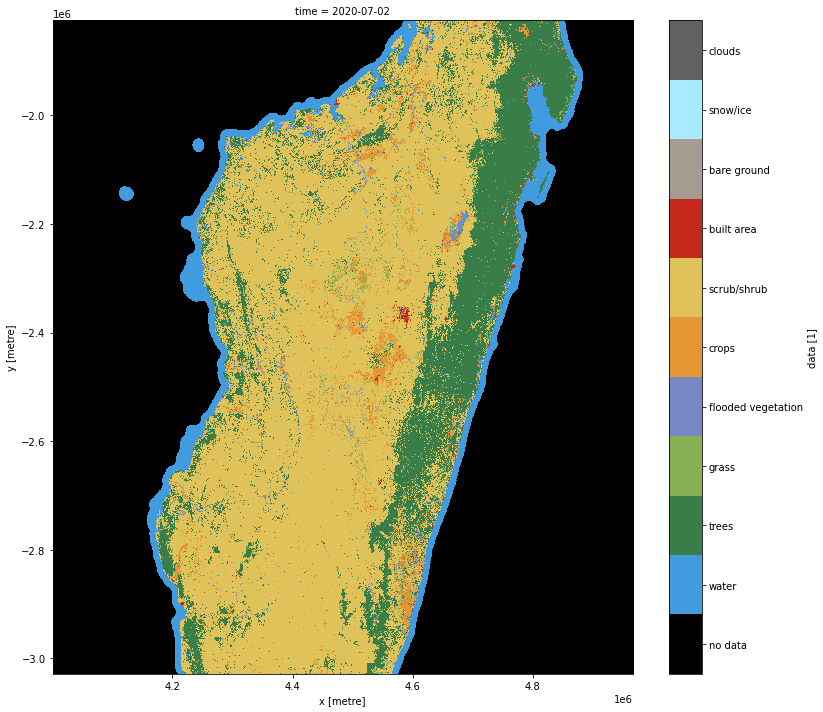

In [6]:
plot_lulc(ds.data, col='time', size=10, legend=True)

## Area calculations

In this example, we will look more closely at the city of Antananarivo, the capital of Madagascar, which can be seen in red in the map above.

As we are looking at a smaller area, we can load the LULC data in 10-m resolution.

In [7]:
lat, lon =  -18.9028, 47.5203
buffer = 0.05

#add lat,lon,buffer to get bounding box
lon_range = (lon-buffer, lon+buffer)
lat_range =  (lat+buffer, lat-buffer)

### View selected location

In [8]:
display_map(x=lon_range, y=lat_range)

### Load LULC data for Antananarivo

In [9]:
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-10, 10), # We use 10-m resolution for smaller areas. 
    'output_crs':'EPSG:6933'
}

ds = dc.load(
    product="io_lulc",
    **query,
    dask_chunks={}
)

/env/lib/python3.8/site-packages/datacube/utils/geometry/_base.py:608: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return type(geom)([segmentize_shapely(g) for g in geom])


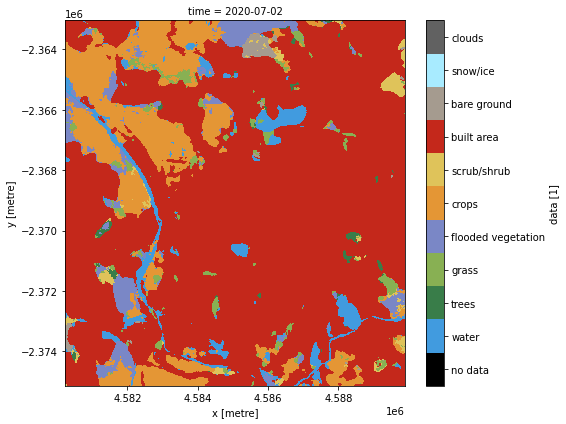

In [10]:
plot_lulc(ds.data, col='time', size=6)

## Investigate the proportion of classes

We can use the numpy `np.unique` function to return the pixel count for each class.

In [11]:
ds_counts = np.array(np.unique(ds.data, return_counts=True))
ds_counts

array([[     1,      2,      3,      4,      5,      6,      7,      8],
       [ 46974,   5722,  22671,  45365, 165491,  12638, 862342,   7657]])

We can see above that result is an array with classes 1:8 which corresponds to water:bareground, and the count of pixels within these classes. Using the resolution we set in our data loading query, we can calculate the total area of each class in square kilometres and plot the results. Does the plot align with the proportions of class we can visualise in the map of Antananarivo?

For more information on area calculations see the water extent calculation section of the Digital Earth Africa Sandbox [training course](https://learn.digitalearthafrica.org/courses/course-v1:digitalearthafrica+DEA101+2021/course/).

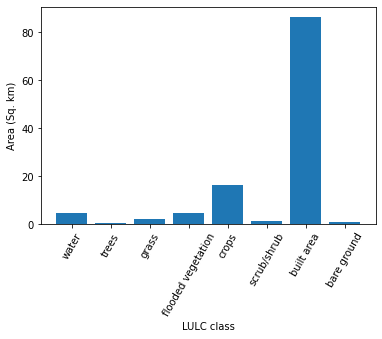

In [12]:
pixel_length = query["resolution"][1]  # in metres, refers to resolution we defined above (-10,10) for Antananarivo
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2
ds_area = np.array(ds_counts[1] * area_per_pixel)

classes = ['water', 'trees', 'grass', 'flooded vegetation', 'crops', 'scrub/shrub', 'built area', 'bare ground']
plt.bar(classes, ds_area)
plt.xticks(rotation=60)
plt.xlabel("LULC class")
plt.ylabel("Area (Sq. km)")
plt.show()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [13]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [14]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-10-27'